In [11]:
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import macd
from ta.trend import ema_indicator
from ta.trend import sma_indicator
from sklearn  import  preprocessing
import sklearn.mixture as mix
from hmmlearn.hmm import GaussianHMM

## Read data

In [19]:
df = pd.read_csv('d1.csv',index_col = 0)
df["return"]=df["Close"].pct_change()
df.index = pd.to_datetime(df.index)
df=df.dropna()

In [20]:
df.head()

,Open,High,Low,Close,Adj Close,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,...,momentum_kama,others_dr,others_dlr,others_cr,EMA10,EMA100,T10Y3M,T10YIE,state,return
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,504.974991,505.384995,504.564987,0.162386,0.250000,...,505.010776,-0.081160,-0.081193,-0.081160,497.535809,503.614767,2.83,1.62,0,-0.000812
2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,508.663320,519.100860,498.225780,4.103909,0.853371,...,509.360835,2.232698,2.208138,2.149726,500.900203,503.860811,2.88,1.63,0,0.022327
2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,509.609993,519.225655,499.994331,3.773734,0.647677,...,510.634148,-0.695676,-0.698107,1.439095,503.000168,504.030894,2.85,1.62,0,-0.006957
2003-01-08,512.450012,512.450012,504.529999,505.309998,505.309998,508.749994,518.012949,499.487039,3.641457,0.314314,...,508.391744,-1.393309,-1.403107,0.025734,503.420137,504.056222,2.81,1.71,0,-0.013933
2003-01-09,505.309998,515.039978,505.309998,514.739990,514.739990,509.748327,519.310508,500.186145,3.751727,0.761011,...,511.063907,1.866180,1.848980,1.892394,505.478292,504.267782,2.99,1.78,1,0.018662


## Data select

In [152]:
def data_select(df,n,year):
    if year==2003:
        train=df.loc[:"2017-12-29",:]
        test=df.loc["2018-01-02":"2021-12-31",:]
    if year==2010:
        train=df.loc["2010-01-04":"2017-12-29",:]
        test=df.loc["2018-01-02":"2021-12-31",:]
    if year==2015:
        train=df.loc["2015-01-02":"2017-12-29",:]
        test=df.loc["2018-01-02":"2021-12-31",:]    
    #only return
    if n==1:
        return (train[["return"]],test[["return"]])
    #return+ohlc
    if n==2:
        return (train[["Open","High","Low","Close","return"]],test[["Open","High","Low","Close","return"]])
    #return+ohlc+tech
    if n==3:
        return (train[['Open', 'High', 'Low', 'Close',"return",'momentum_rsi','trend_macd','volatility_dcp','trend_cci']]
               ,test[['Open', 'High', 'Low', 'Close',"return",'momentum_rsi','trend_macd','volatility_dcp','trend_cci']])
    #return+ohlc+eco
    if n==4:
        return (train[["return",'Open', 'High', 'Low', 'Close','T10YIE']],test[["return",'Open', 'High', 'Low', 'Close','T10YIE']])
    #return+ohlc+tech+eco
    if n==5:
        return (train[['Open', 'High', 'Low', 'Close',"return",'momentum_rsi','trend_macd','volatility_dcp','trend_cci','T10YIE']]
               ,test[['Open', 'High', 'Low', 'Close',"return",'momentum_rsi','trend_macd','volatility_dcp','trend_cci','T10YIE']])
    #return+eco
    if n==6:
        return (train[["return",'T10YIE']],test[["return",'T10YIE']])
    #return+tech
    if n==7:
        return (train[["return",'momentum_rsi','trend_macd','volatility_dcp','trend_cci']]
               ,test[["return",'momentum_rsi','trend_macd','volatility_dcp','trend_cci']])    
    #return+tech+eco
    if n==8:
        return (train[["return",'momentum_rsi','trend_macd','volatility_dcp','trend_cci','T10YIE']]
               ,test[["return",'momentum_rsi','trend_macd','volatility_dcp','trend_cci','T10YIE']])

### Model select

In [54]:
def model_cap(model,train,test):
    if model=="HMM":
        #select features and set index
        train=train
        test=test
        #scale the train/test
        scaler=preprocessing.StandardScaler()
        train=scaler.fit_transform(train)
        test=scaler.fit_transform(test)
        model=GaussianHMM(n_components=3).fit(train)
        hidden_states = model.predict(test)
        for i in range(model.n_components):
            print("{t}th hidden state".format(t=i))
            print("mean = ", model.means_[i])
        visual=df.loc["2018-01-02":"2021-12-31"]
        visual["State"]=hidden_states
        colors= {0:'red', 1:'green', 2:"blue"}
        plt.figure(figsize=(20,8))
        plt.scatter(visual.index, visual['Close'], c=visual['State'].map(colors))
        return visual[["Open","High","Low","Close","State"]]
    if model=="GMM":
        #select features and set index
        train=train
        test=test
        #scale the train/test
        scaler=preprocessing.StandardScaler()
        train=scaler.fit_transform(train)
        test=scaler.fit_transform(test)
        model=mix.GaussianMixture(n_components=3).fit(train)
        hidden_states = model.predict(test)
        for i in range(model.n_components):
            print("{t}th hidden state".format(t=i))
            print("mean = ", model.means_[i])
        visual=df.loc["2018-01-02":"2021-12-31"]
        visual["State"]=hidden_states
        colors= {0:'red', 1:'green', 2:"blue"}
        plt.figure(figsize=(20,8))
        plt.scatter(visual.index, visual['Close'], c=visual['State'].map(colors))
        return visual[["Open","High","Low","Close","State"]] 

## HMM

0th hidden state
mean =  [0.03046201]
1th hidden state
mean =  [0.04787224]
2th hidden state
mean =  [-0.24124891]
0th hidden state
mean =  [-0.94624971 -0.94610301 -0.94633557 -0.94624529 -0.00123652]
1th hidden state
mean =  [1.31649013 1.31773392 1.31516691 1.31641349 0.00887186]
2th hidden state
mean =  [-0.26028698 -0.26155591 -0.25900601 -0.26022201 -0.00680712]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states
C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


0th hidden state
mean =  [-0.52776851 -0.52969263 -0.52027013 -0.52274324  0.16210809  0.68452956
  0.46183091  0.73569326  0.72958706]
1th hidden state
mean =  [1.3333562  1.33462799 1.33195345 1.33322926 0.00760937 0.12027626
 0.21734931 0.08887613 0.01722588]
2th hidden state
mean =  [-0.67508615 -0.67397556 -0.68295026 -0.68116571 -0.20776503 -0.96503786
 -0.78661875 -0.99697485 -0.91813372]
0th hidden state
mean =  [-0.00340008 -0.9503978  -0.9500629  -0.95081805 -0.95047533 -0.22691231]
1th hidden state
mean =  [-0.00381613 -0.26677111 -0.2681808  -0.26516554 -0.26660188  0.66449223]
2th hidden state
mean =  [ 0.00795349  1.31903087  1.32026568  1.31766602  1.3189226  -0.50813743]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states
C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states
C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

0th hidden state
mean =  [-0.71103401 -0.70957705 -0.71859143 -0.71651212 -0.18423455 -0.92546175
 -0.74850655 -0.94839659 -0.87114068 -0.0595278 ]
1th hidden state
mean =  [-0.49878363 -0.50101851 -0.49132208 -0.49409273  0.14766313  0.6726425
  0.4451983   0.71755432  0.71352516  0.47039813]
2th hidden state
mean =  [ 1.32999542  1.33125597  1.32851234  1.32979873  0.00574126  0.11341737
  0.21267867  0.08166523  0.00841093 -0.51542688]
0th hidden state
mean =  [0.00405085 0.64343525]
1th hidden state
mean =  [ 0.02944082 -0.62886041]
2th hidden state
mean =  [-0.16789753 -2.19994632]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


0th hidden state
mean =  [0.19176838 0.91690376 0.67834781 0.90416854 0.86823397]
1th hidden state
mean =  [-0.31165658 -1.2687898  -1.04072811 -1.35799767 -1.32355753]
2th hidden state
mean =  [ 0.01748347 -0.1126569   0.00713444 -0.01636946  0.00159859]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


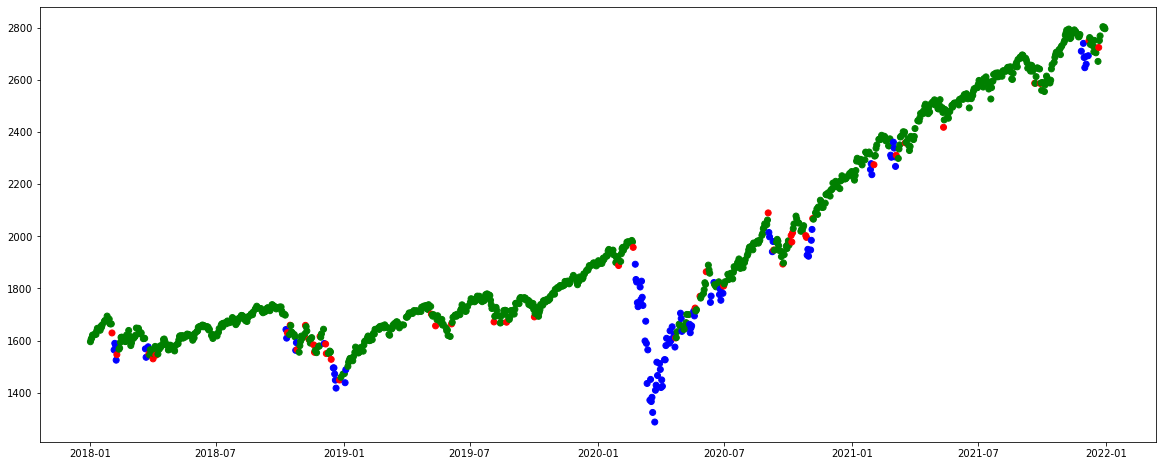

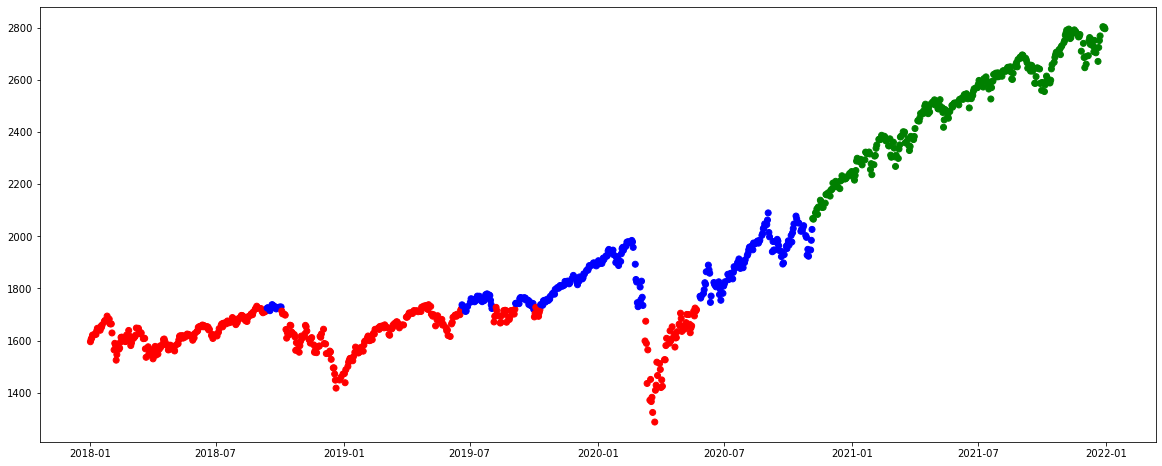

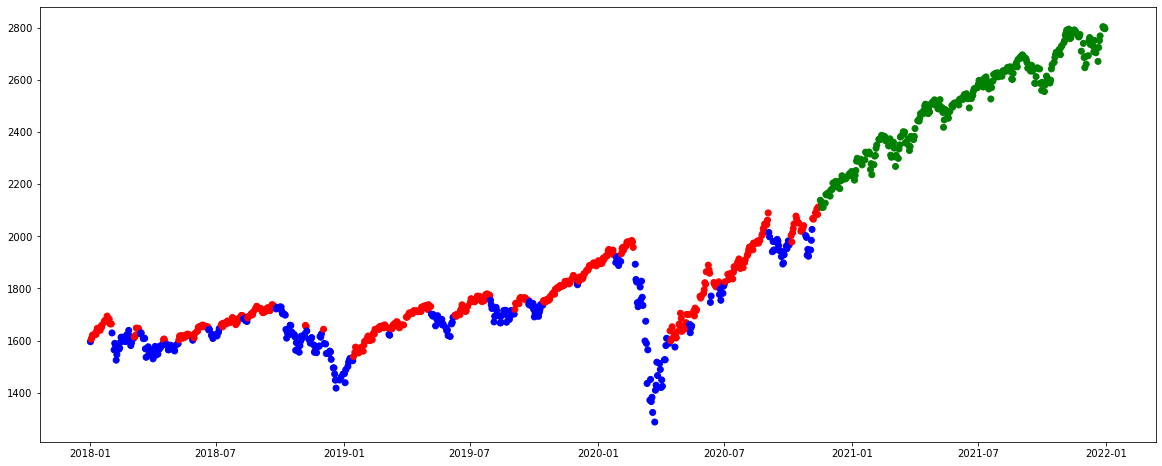

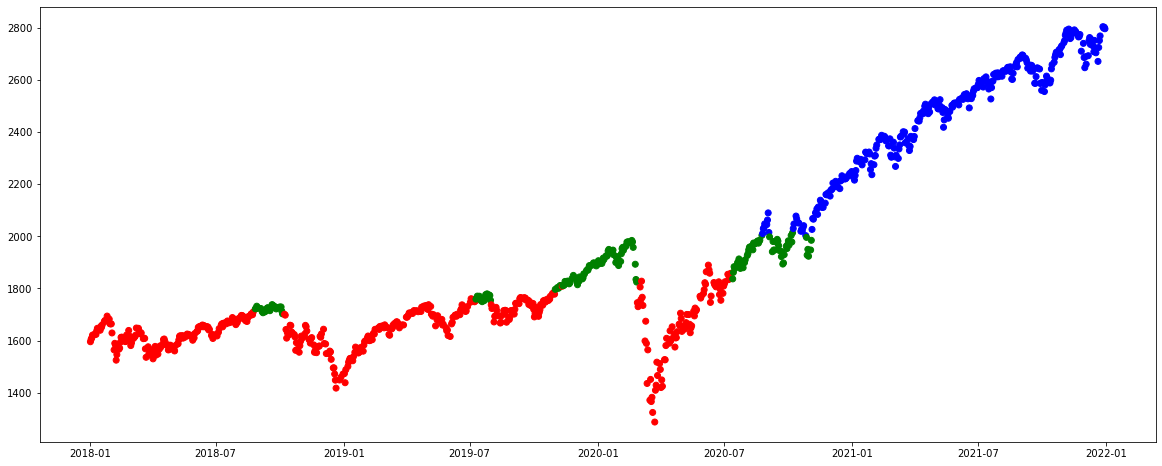

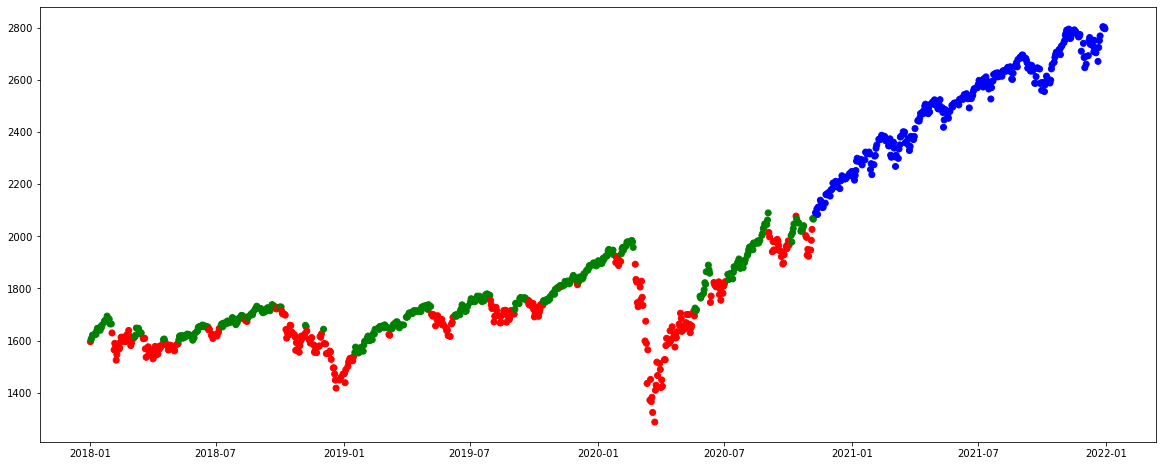

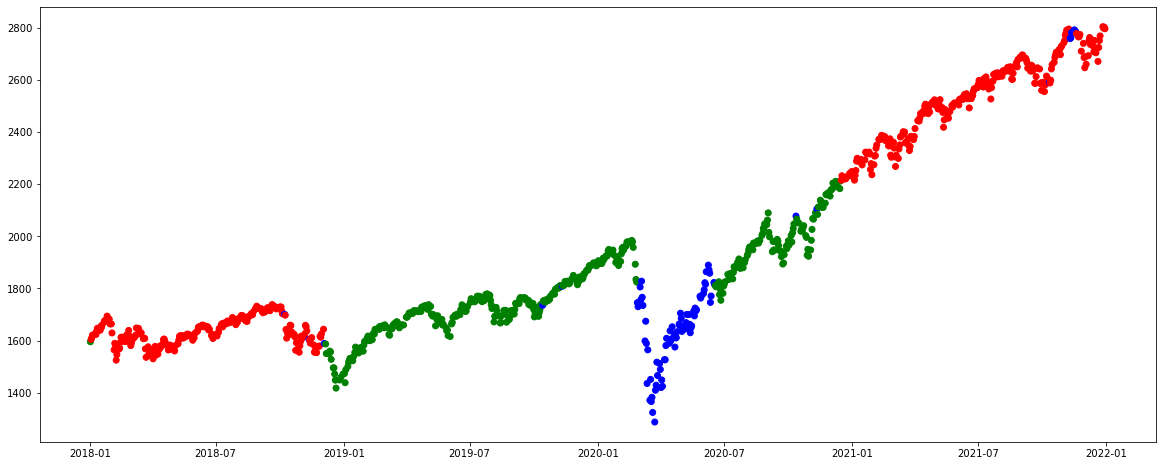

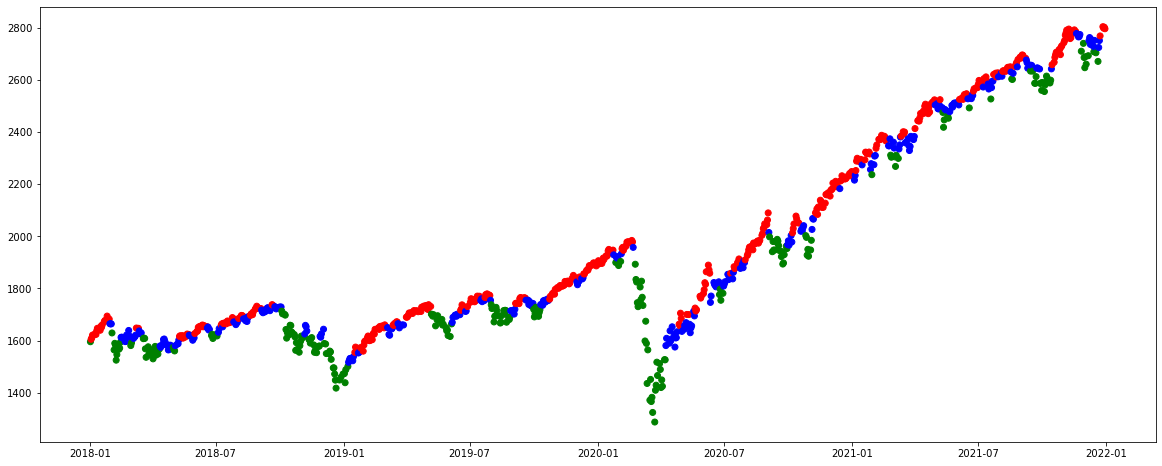

In [65]:
for i in range(1,8):
    a=data_select(df,i)
    output=model_cap("HMM",a[0],a[1])
    output.to_csv("data_hmm_{t}.csv".format(t=i)) 

## GMM

0th hidden state
mean =  [0.05316075]
1th hidden state
mean =  [-0.71589571]
2th hidden state
mean =  [0.48945028]
0th hidden state
mean =  [-0.54693779 -0.55069879 -0.54071447 -0.54507373  0.05241233]
1th hidden state
mean =  [1.34654568 1.34784899 1.35067332 1.35176142 0.12001055]
2th hidden state
mean =  [-0.29862858 -0.28916807 -0.32337728 -0.31180042 -0.33180088]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states
C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


0th hidden state
mean =  [1.32412886 1.324882   1.32778036 1.32857168 0.10603985 0.30536387
 0.41829348 0.27618056 0.19894261]
1th hidden state
mean =  [-0.33541878 -0.32557857 -0.3574169  -0.34607497 -0.27364243 -0.85082959
 -0.97710242 -0.71926688 -0.6810185 ]
2th hidden state
mean =  [-0.54935098 -0.55343407 -0.54294454 -0.5476116   0.04877118  0.16406042
  0.15392112  0.1294925   0.15451385]
0th hidden state
mean =  [ 0.03945706 -0.55310426 -0.55673587 -0.54743697 -0.55163006  0.48696092]
1th hidden state
mean =  [ 0.10120348  1.28236884  1.28412074  1.28502204  1.28656183 -0.40329698]
2th hidden state
mean =  [-0.33543502 -0.49607033 -0.48649488 -0.52138082 -0.50939544 -0.95990705]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states
C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


0th hidden state
mean =  [ 1.08530218  1.08665488  1.08785832  1.08942829  0.1054116   0.16088763
  0.26425294  0.14207721  0.08981171 -0.23775503]
1th hidden state
mean =  [-0.42221887 -0.41233846 -0.44572295 -0.43425148 -0.31747714 -0.86073014
 -1.05653793 -0.70789615 -0.67090162 -0.98138262]
2th hidden state
mean =  [-0.58285754 -0.58713769 -0.57654366 -0.58151267  0.03779814  0.18614625
  0.18376728  0.14655717  0.16893656  0.49439536]
0th hidden state
mean =  [-0.21688369 -1.93858665]
1th hidden state
mean =  [-0.05439002 -0.46198617]
2th hidden state
mean =  [0.07644905 0.66298594]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states
C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


0th hidden state
mean =  [-0.0393325  -0.31295162 -0.05153927 -0.33822218 -0.30917678]
1th hidden state
mean =  [0.1387588  0.95947929 0.63960813 0.93233126 0.89626388]
2th hidden state
mean =  [-0.1987947  -1.18867806 -1.50513015 -1.00020528 -1.03393423]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


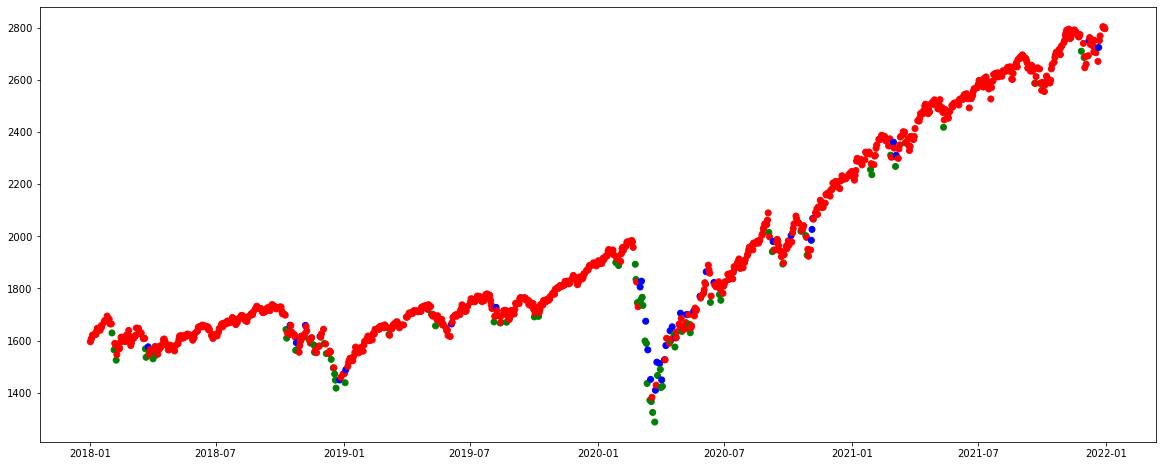

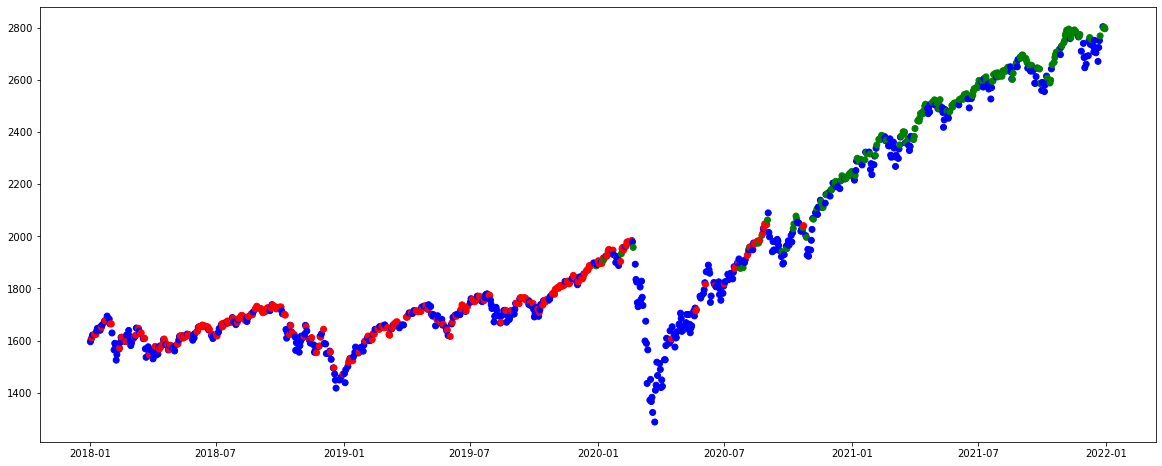

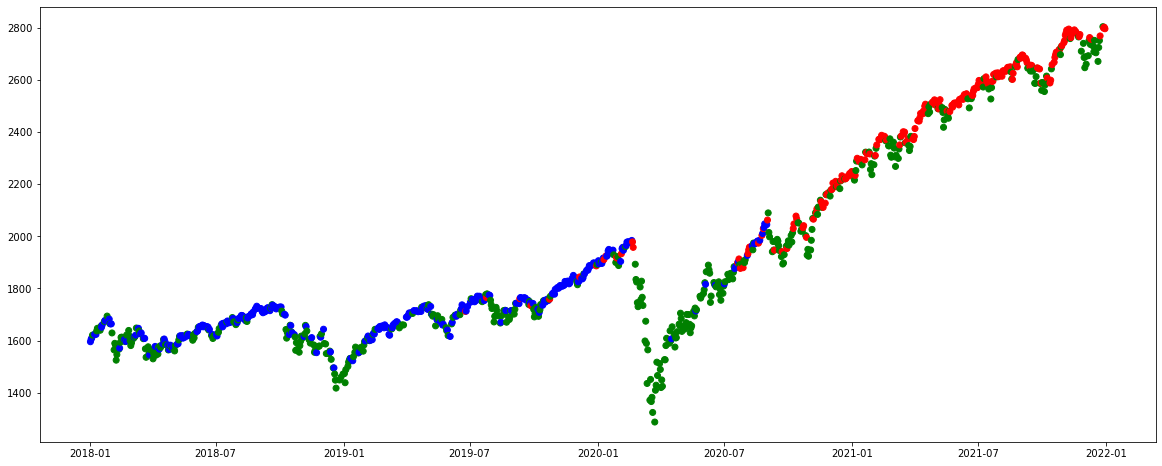

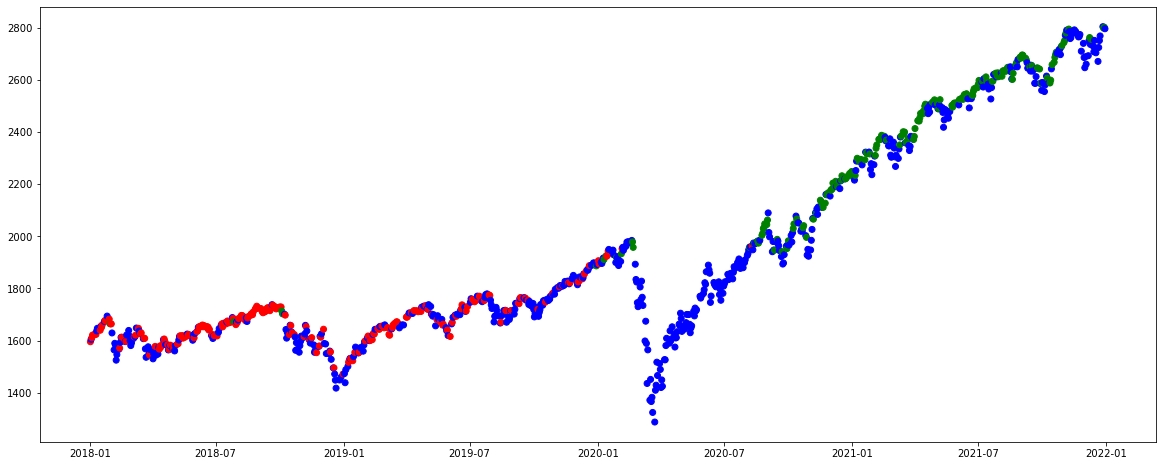

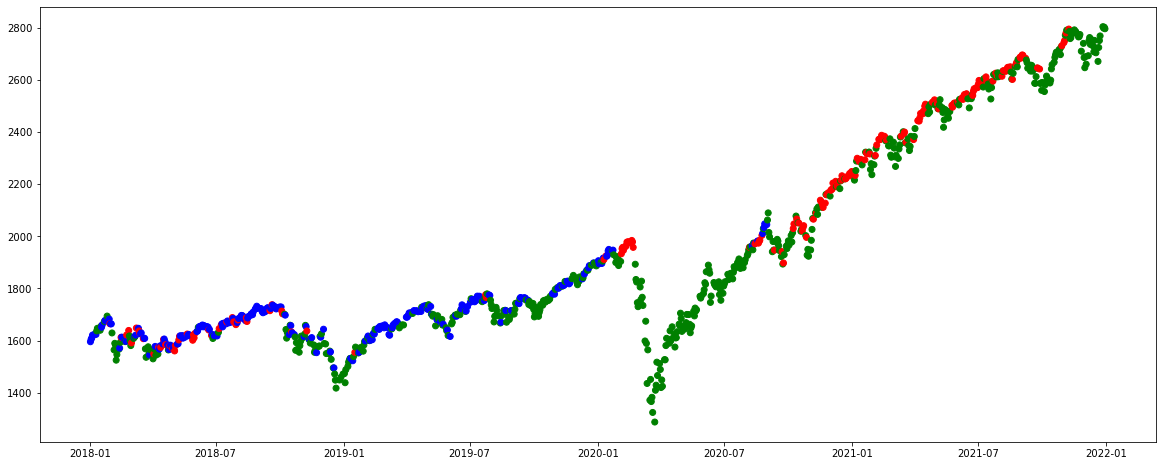

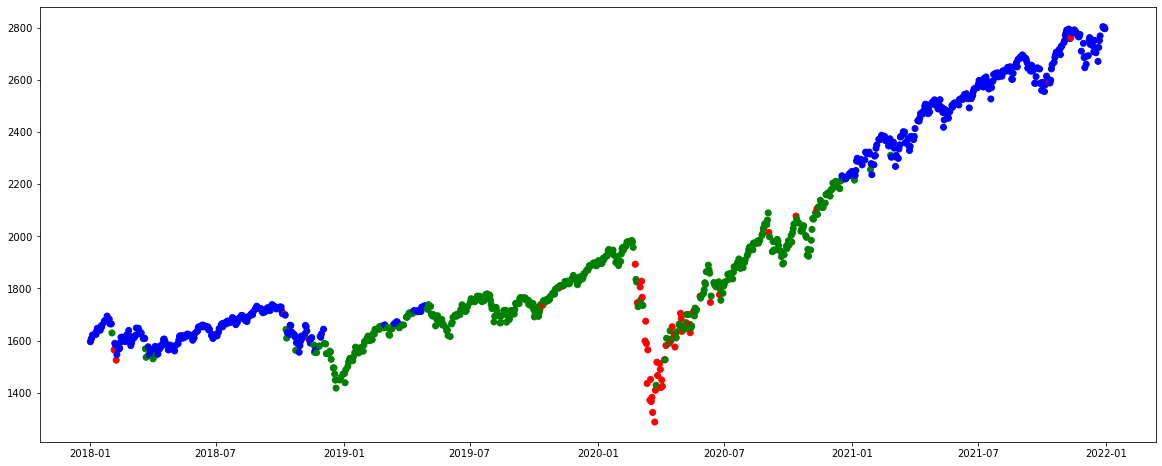

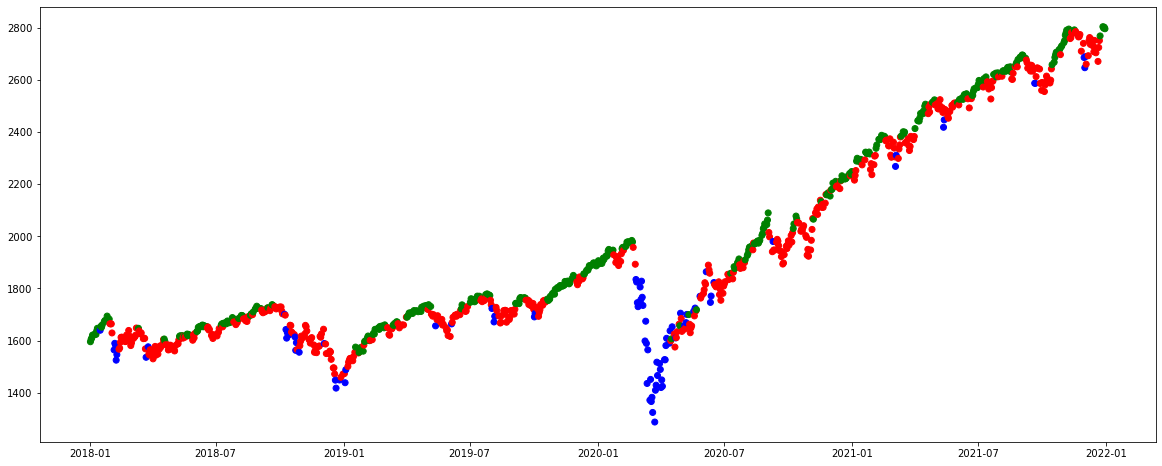

In [66]:
for i in range(1,8):
    a=data_select(df,i)
    output=model_cap("GMM",a[0],a[1])
    output.to_csv("data_gmm_{t}.csv".format(t=i)) 

### HMM 1&7

colors= {0:'red', 1:'green', 2:"blue"}

#### HMM1

0th hidden state
mean =  [-0.2669368]
1th hidden state
mean =  [0.04727417]
2th hidden state
mean =  [0.05467352]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


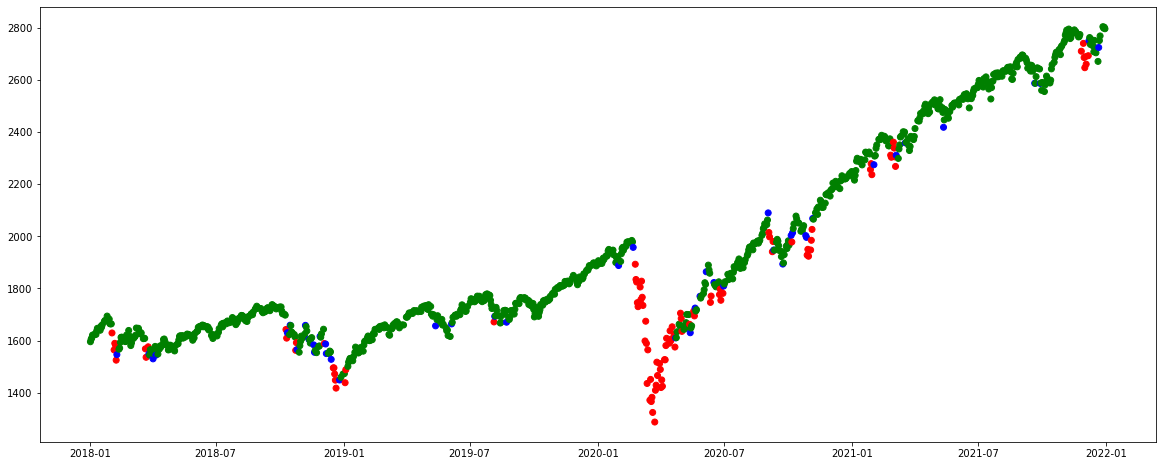

In [68]:
a=data_select(df,1)
output=model_cap("HMM",a[0],a[1])

In [69]:
output

,Open,High,Low,Close,State
Date,,,,,
2018-01-02,1585.089966,1595.939941,1585.089966,1595.869995,1
2018-01-03,1595.839966,1605.890015,1595.839966,1605.189941,1
2018-01-04,1605.699951,1613.839966,1605.699951,1611.020020,1
2018-01-05,1612.140015,1621.479980,1612.140015,1621.369995,1
2018-01-08,1621.280029,1624.780029,1617.640015,1624.349976,1
...,...,...,...,...,...
2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,1
2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,1
2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,1


In [70]:
output['State'] = output['State'].map({1: 1, 0: -1,2: 0})

In [73]:
output.to_csv("data_hmm_{t}.csv".format(t=1)) 

#### HMM1 all data y

In [115]:
b=data_select(df,1)
train=b[0]
test=b[1]
#scale the train/test
scaler=preprocessing.StandardScaler()
train=scaler.fit_transform(train)
test=scaler.fit_transform(test)
model=GaussianHMM(n_components=3).fit(train)
hidden_states = model.predict(test)
train_y=model.decode(train)[1]

In [119]:
df_before=df.loc[:"2017-12-29",["Open","High","Low","Close"]]
df_after=df.loc["2018-01-02":"2021-12-31",["Open","High","Low","Close"]]
df_before["State"]=train_y
df_after["State"]=hidden_states

In [121]:
df_output=pd.concat([df_before,df_after],axis=0)

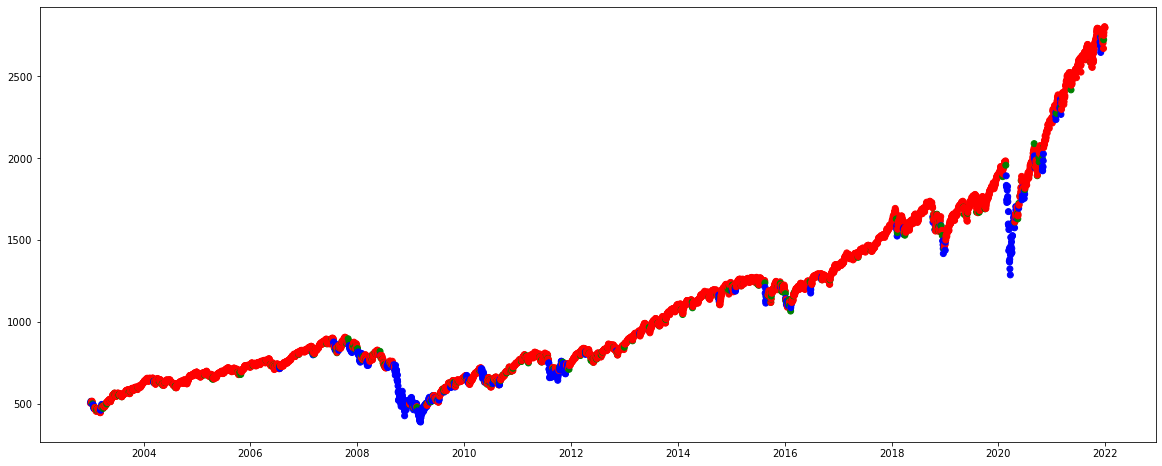

In [123]:
colors= {0:'red', 1:'green', 2:"blue"}
plt.figure(figsize=(20,8))
plt.scatter(df_output.index, df_output['Close'], c=df_output['State'].map(colors))

In [124]:
df_output['State'] = df_output['State'].map({0: 1, 2: -1,1: 0})

In [125]:
df_output.to_csv("data_hmm_{t}_2003.csv".format(t=1)) 

#### HMM7

0th hidden state
mean =  [ 0.01750648 -0.11162611  0.00799424 -0.01493193  0.00288719]
1th hidden state
mean =  [0.19191386 0.91753914 0.67870352 0.90456851 0.86866252]
2th hidden state
mean =  [-0.31128621 -1.26807084 -1.04008348 -1.35736829 -1.32290796]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


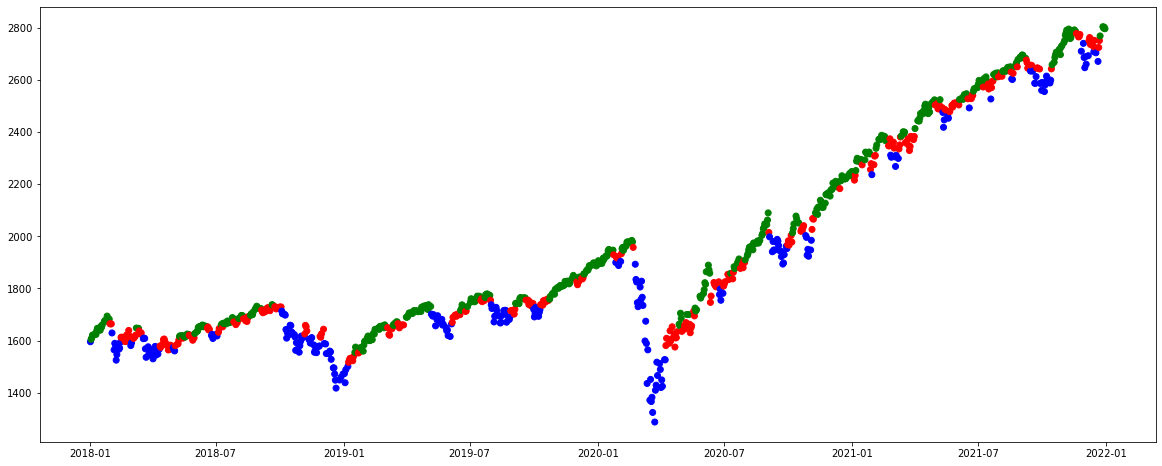

In [94]:
a=data_select(df,7)
output=model_cap("HMM",a[0],a[1])

In [95]:
output['State'] = output['State'].map({1: 1, 0: 1,2: -1})

In [96]:
output.to_csv("data_hmm_{t}_revised.csv".format(t=7)) 

#### HMM7 all year data

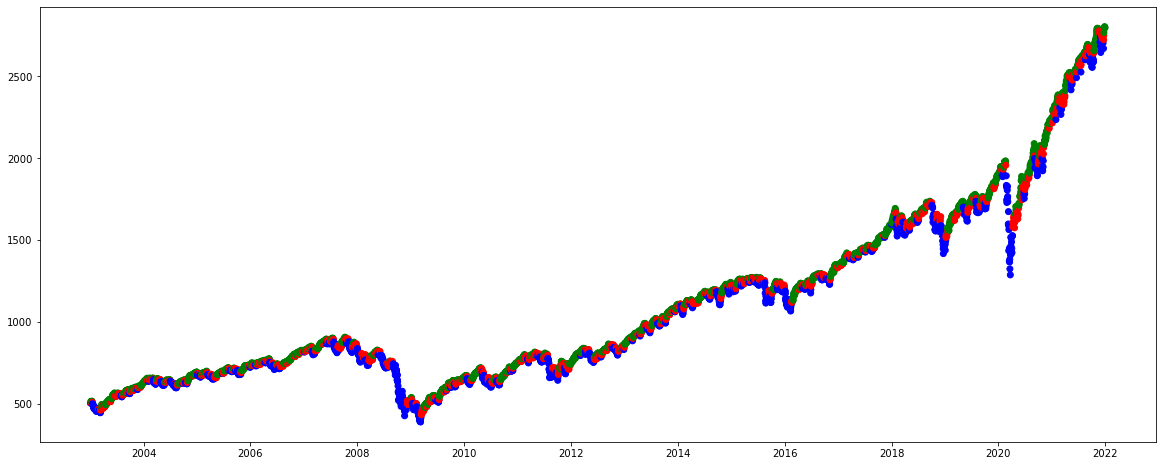

In [126]:
b=data_select(df,7)
train=b[0]
test=b[1]
#scale the train/test
scaler=preprocessing.StandardScaler()
train=scaler.fit_transform(train)
test=scaler.fit_transform(test)
model=GaussianHMM(n_components=3).fit(train)
hidden_states = model.predict(test)
train_y=model.decode(train)[1]
df_before=df.loc[:"2017-12-29",["Open","High","Low","Close"]]
df_after=df.loc["2018-01-02":"2021-12-31",["Open","High","Low","Close"]]
df_before["State"]=train_y
df_after["State"]=hidden_states
df_output=pd.concat([df_before,df_after],axis=0)
colors= {0:'red', 1:'green', 2:"blue"}
plt.figure(figsize=(20,8))
plt.scatter(df_output.index, df_output['Close'], c=df_output['State'].map(colors))

In [128]:
df_output['State'] = df_output['State'].map({1: 1, 0: 1,2: -1})

In [129]:
df_output.to_csv("data_hmm_{t}_revised_2003.csv".format(t=7)) 

#### HMM8

0th hidden state
mean =  [0.18802856 0.91673482 0.67861886 0.90214453 0.86684713 0.10454884]
1th hidden state
mean =  [-0.31165875 -1.27221051 -1.04528578 -1.36028867 -1.32624926 -0.14180084]
2th hidden state
mean =  [ 0.02102191 -0.11486283  0.00596625 -0.01781948 -0.00026068 -0.01598969]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


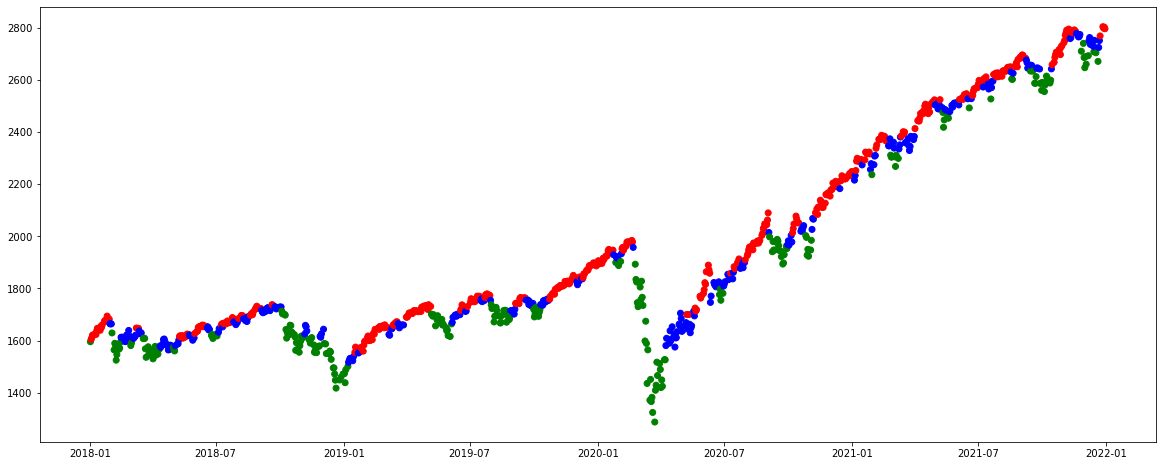

In [92]:
a=data_select(df,8)
output=model_cap("HMM",a[0],a[1])

In [93]:
output['State'] = output['State'].map({0: 1, 1: -1,2: 1})

In [ ]:
plt.figure(figsize=(20,8))
plt.scatter(output.index, output['Close'], c=output['State'].map(color1))

In [82]:
output.to_csv("data_hmm_{t}.csv".format(t=8)) 

### GMM 1，7，8

colors= {0:'red', 1:'green', 2:"blue"}

#### GMM1

0th hidden state
mean =  [0.0518719]
1th hidden state
mean =  [0.48741858]
2th hidden state
mean =  [-0.75123278]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


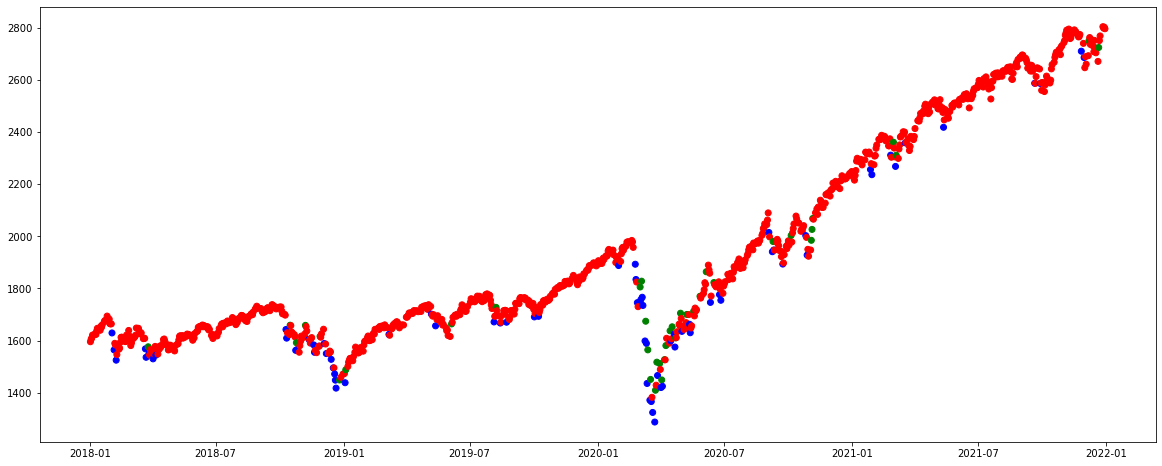

In [83]:
a=data_select(df,1)
output=model_cap("GMM",a[0],a[1])

In [84]:
output['State'] = output['State'].map({0: 1, 2: -1,1: 0})

In [85]:
output.to_csv("data_gmm_{t}.csv".format(t=1)) 

#### GMM1 all year data

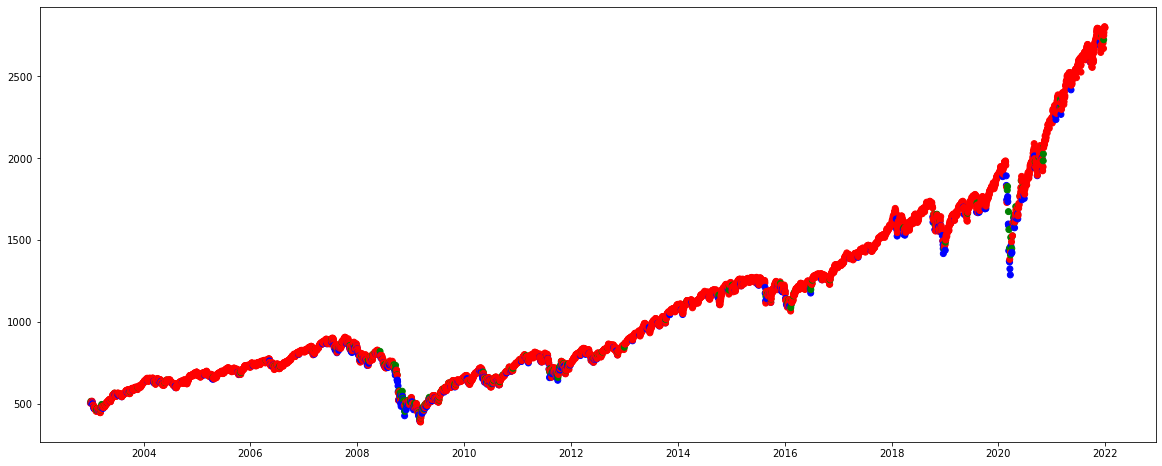

In [139]:
b=data_select(df,1)
train=b[0]
test=b[1]
#scale the train/test
scaler=preprocessing.StandardScaler()
train=scaler.fit_transform(train)
test=scaler.fit_transform(test)
model=mix.GaussianMixture(n_components=3).fit(train)
hidden_states = model.predict(test)
train_y=model.predict(train)
df_before=df.loc[:"2017-12-29",["Open","High","Low","Close"]]
df_after=df.loc["2018-01-02":"2021-12-31",["Open","High","Low","Close"]]
df_before["State"]=train_y
df_after["State"]=hidden_states
df_output=pd.concat([df_before,df_after],axis=0)
colors= {0:'red', 1:'green', 2:"blue"}
plt.figure(figsize=(20,8))
plt.scatter(df_output.index, df_output['Close'], c=df_output['State'].map(colors))

In [141]:
df_output['State'] = df_output['State'].map({0: 1, 2: -1,1: 0})

In [144]:
df_output.to_csv("data_gmm_{t}_2003.csv".format(t=1)) 

#### GMM7

0th hidden state
mean =  [0.13892902 0.95928045 0.63961823 0.93227651 0.896154  ]
1th hidden state
mean =  [-0.03950064 -0.31322777 -0.05168234 -0.33862265 -0.30951746]
2th hidden state
mean =  [-0.19862655 -1.18810797 -1.50411274 -0.99969215 -1.03336298]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


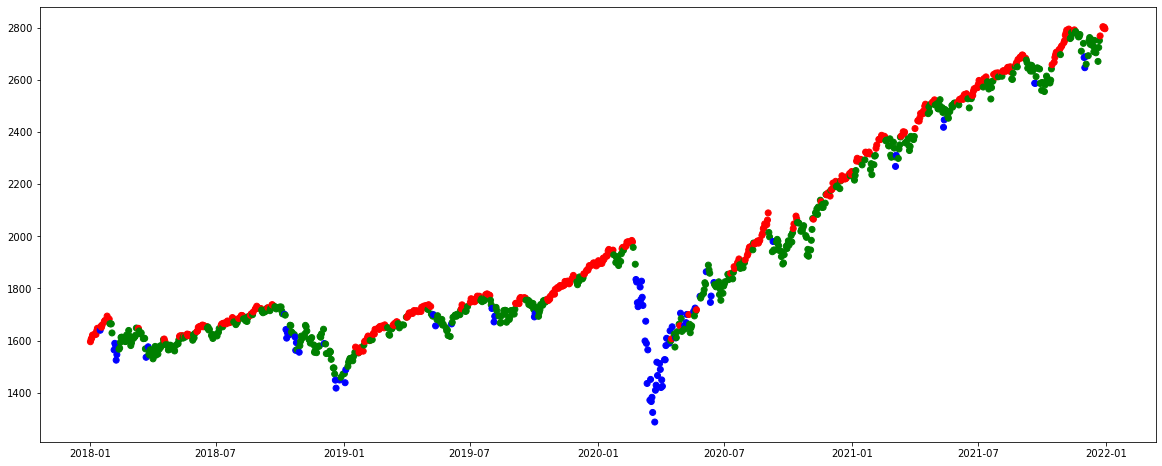

In [137]:
a=data_select(df,7)
output=model_cap("GMM",a[0],a[1])

In [99]:
output['State'] = output['State'].map({2: 1, 0: -1,1: -1})

In [100]:
output.to_csv("data_gmm_{t}_revised.csv".format(t=7)) 

#### GMM8

In [109]:
a=data_select(df,8)
train=a[0]
test=a[1]
#scale the train/test
scaler=preprocessing.StandardScaler()
train=scaler.fit_transform(train)
test=scaler.fit_transform(test)
model=GaussianHMM(n_components=3).fit(train)
hidden_states = model.predict(test)
train_y=model.decode(train)
#output=model_cap("GMM",a[0],a[1])

In [114]:
train.shape

(3775, 6)

## HMM1&7 3 period

#### HMM1 2003

0th hidden state
mean =  [-0.25535977]
1th hidden state
mean =  [0.04376175]
2th hidden state
mean =  [0.04748814]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


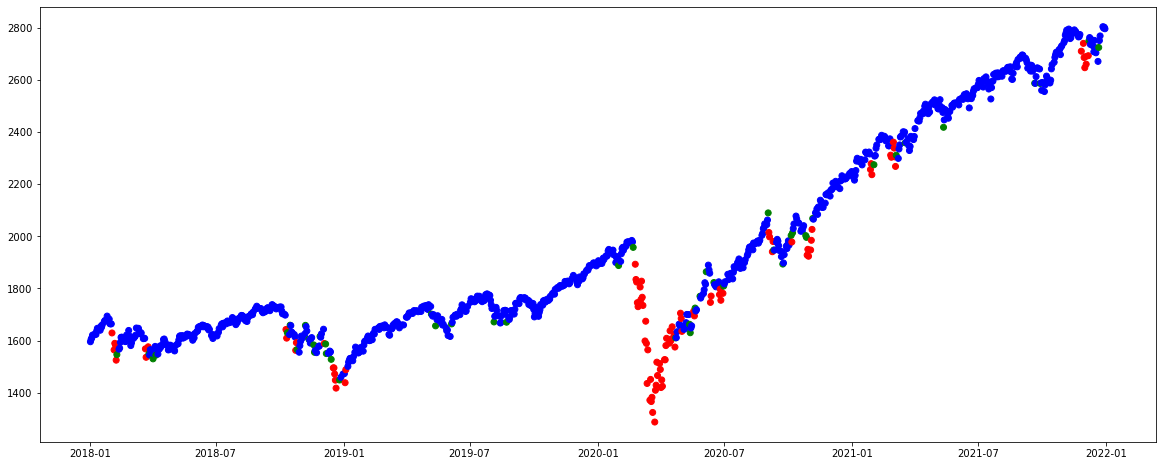

In [158]:
a=data_select(df,1,2003)
output=model_cap("HMM",a[0],a[1])

In [159]:
output['State'] = output['State'].map({2: 1, 0: -1,1: 0})
output.to_csv("data_hmm_{t}_2003.csv".format(t=1)) 

#### HMM1 2010

0th hidden state
mean =  [0.0418074]
1th hidden state
mean =  [0.47581627]
2th hidden state
mean =  [-0.73948124]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


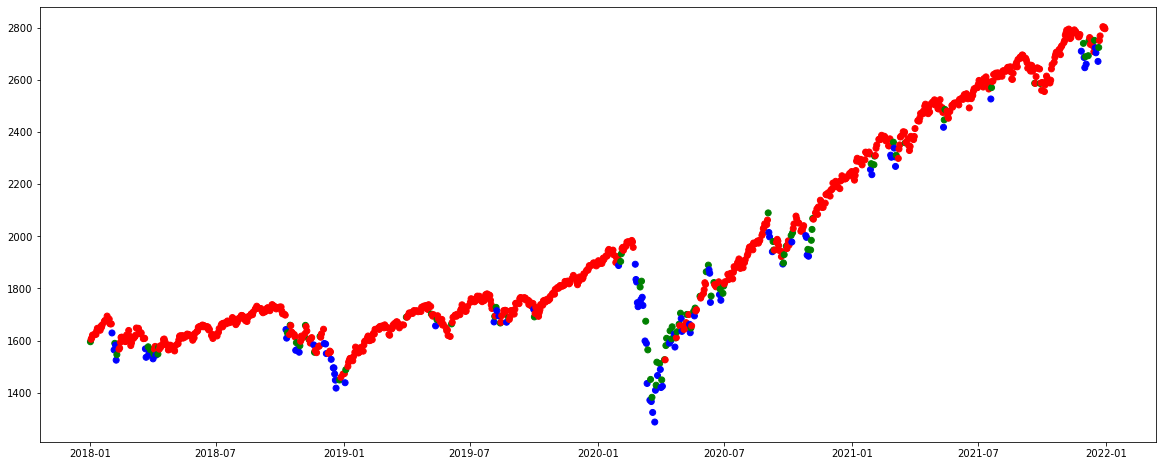

In [160]:
a=data_select(df,1,2010)
output=model_cap("HMM",a[0],a[1])

In [161]:
output['State'] = output['State'].map({0: 1, 2: -1,1: 0})
output.to_csv("data_hmm_{t}_2010.csv".format(t=1)) 

#### HMM1 2015

0th hidden state
mean =  [0.74460107]
1th hidden state
mean =  [-0.90946326]
2th hidden state
mean =  [-0.01115564]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


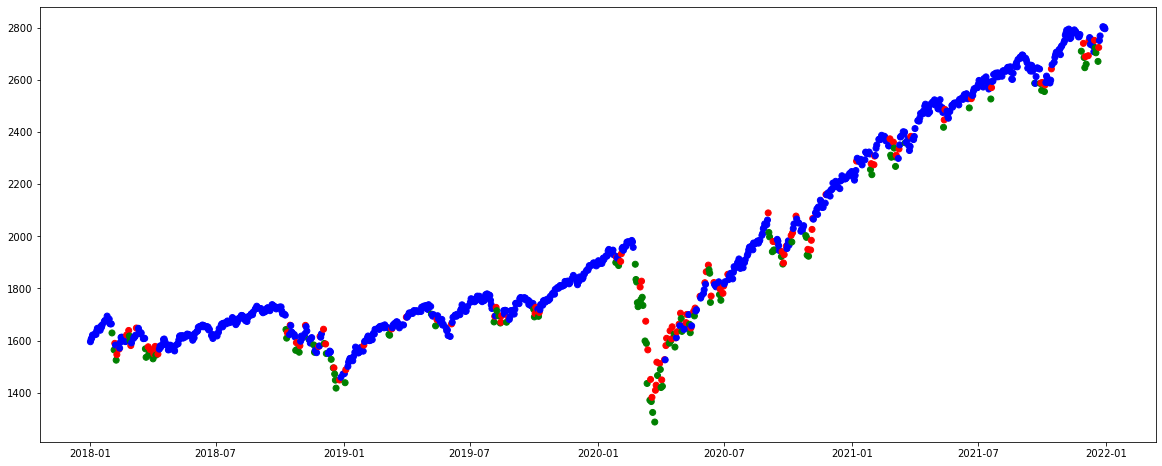

In [163]:
a=data_select(df,1,2015)
output=model_cap("HMM",a[0],a[1])

In [164]:
output['State'] = output['State'].map({2: 1, 1: -1,0: 0})
output.to_csv("data_hmm_{t}_2015.csv".format(t=1)) 

#### GMM1 2003

0th hidden state
mean =  [-0.71589571]
1th hidden state
mean =  [0.05316075]
2th hidden state
mean =  [0.48945028]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


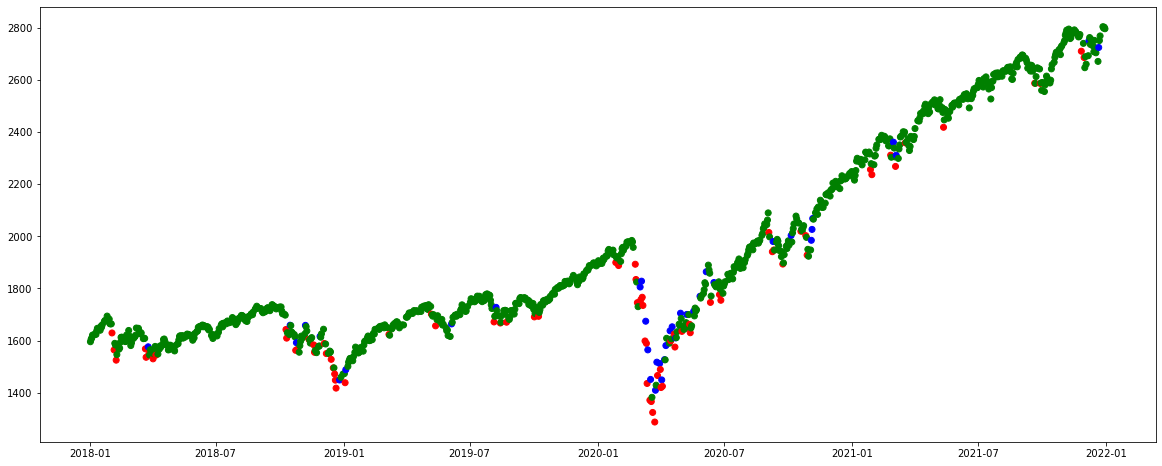

In [165]:
a=data_select(df,1,2003)
output=model_cap("GMM",a[0],a[1])

In [166]:
output['State'] = output['State'].map({1: 1, 0: -1,2: 0})
output.to_csv("data_gmm_{t}_2003.csv".format(t=1)) 

#### GMM1 2010

0th hidden state
mean =  [-1.07919274]
1th hidden state
mean =  [0.8048424]
2th hidden state
mean =  [0.03050935]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


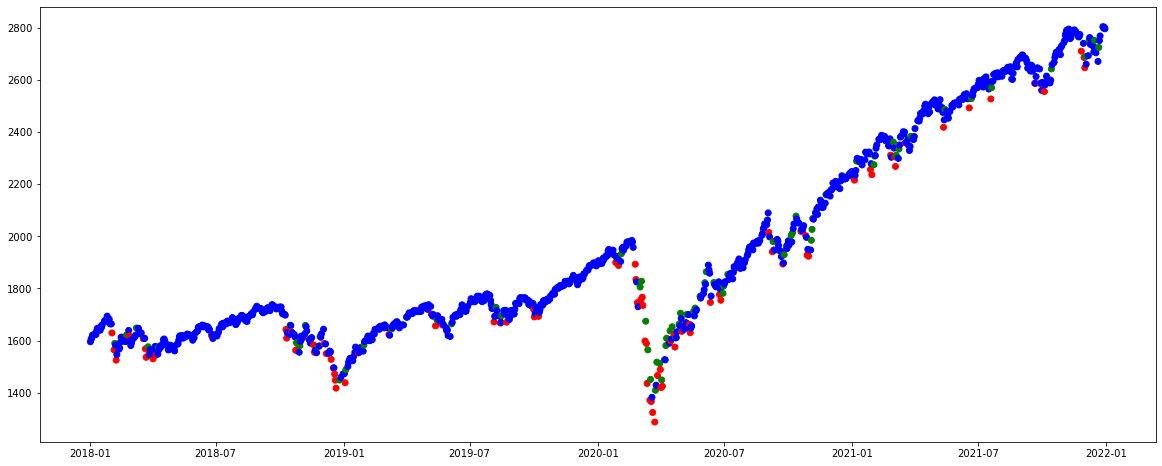

In [167]:
a=data_select(df,1,2010)
output=model_cap("GMM",a[0],a[1])

In [168]:
output['State'] = output['State'].map({2: 1, 0: -1,1: 0})
output.to_csv("data_gmm_{t}_2010.csv".format(t=1)) 

#### GMM1 2015

0th hidden state
mean =  [1.19123554]
1th hidden state
mean =  [-0.02955757]
2th hidden state
mean =  [-1.33665031]


C:\Users\Heking\AppData\Local\Temp/ipykernel_30988/4051454104.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual["State"]=hidden_states


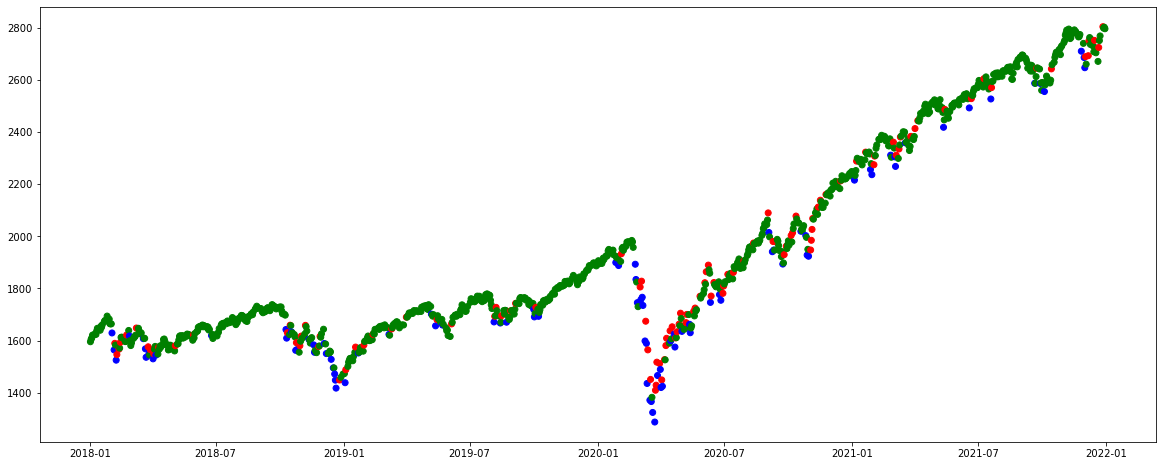

In [169]:
a=data_select(df,1,2015)
output=model_cap("GMM",a[0],a[1])

In [170]:
output['State'] = output['State'].map({1: 1, 2: -1,0: 0})
output.to_csv("data_gmm_{t}_2015.csv".format(t=1)) 

### GMM1 3 period

In [ ]:
for year in [2003,2010,2015]:
    a=data_select(df,1,year)
    output=model_cap("GMM",a[0],a[1])
    output.to_csv("data_gmm_{t}_{m}.csv".format(t=1,m=year)) 